In [2]:
#!pip install phrank
#!pip install umap
#!pip uninstall umap
#!pip install umap-learn
#!pip install datashader
#!pip install colorcet
#!pip install holoviews

import Phrank_modified as Phrank_modified
import phrank_utils_modified as phrank_utils
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import umap.umap_ as umap
import math


In [3]:
DAG="hpo_dag_2021-11-22.txt"
DISEASE_TO_PHENO="pheno_to_disease_2021-11-22.txt"
DISEASE_TO_GENE="gene_to_disease_2021-11-22.txt"
GENE_TO_PHENO="phenotype_to_gene_2021-11-22.txt"
PHENO_DICT="hpo_dict_sig_updated_fill_hpo.tsv"

p_hpo = Phrank_modified.Phrank(DAG, diseaseannotationsfile=DISEASE_TO_PHENO, diseasegenefile=DISEASE_TO_GENE,\
                               geneannotationsfile=GENE_TO_PHENO)



In [4]:
dag_file=pd.read_csv(DAG,sep='\t',header=None)
dis_pheno=pd.read_csv(DISEASE_TO_PHENO,sep='\t',header=None)
dis_gene=pd.read_csv(DISEASE_TO_GENE,sep='\t',header=None)
gene_pheno=pd.read_csv(GENE_TO_PHENO,sep='\t',header=None)

# Read in HPO terms of 434 patients with at least one (out of 657) significant gene

In [5]:
pheno_dict=pd.read_csv(PHENO_DICT,sep='\t')

In [6]:
col_names_nan=pheno_dict.columns[pheno_dict.isna().any()].tolist()
pheno_dict = pheno_dict.drop(col_names_nan, axis=1)
print("The number of patients with HPO terms: ",len(pheno_dict.columns))

The number of patients with HPO terms:  430


# Compute pair-wise normalized similarity scores

In [7]:
#unscaled phrank score
similarity_score=dict()
for i in range(len(pheno_dict.columns)):
    if i == len(pheno_dict.columns)-1:
        break
    phenotypeset1=pheno_dict[pheno_dict.columns[i]][0].split(",")
    for j in range(i+1,len(pheno_dict.columns)):
        phenotypeset2=pheno_dict[pheno_dict.columns[j]][0].split(",")
        matchscore = p_hpo.compute_phenotype_match(phenotypeset1, phenotypeset2)
        similarity_score[pheno_dict.columns[i]+'_'+pheno_dict.columns[j]]=matchscore
        

In [8]:
pd.Series(similarity_score.values()).describe()

count    92235.000000
mean        22.460308
std         21.740182
min          0.000984
25%          8.142180
50%         16.368360
75%         29.876643
max        560.870062
dtype: float64

(array([1.5204e+04, 1.7307e+04, 1.4697e+04, 1.1277e+04, 8.4500e+03,
        6.2440e+03, 4.6840e+03, 3.5740e+03, 2.5280e+03, 1.9990e+03,
        1.4150e+03, 1.0720e+03, 8.0900e+02, 6.2600e+02, 4.4200e+02,
        3.3100e+02, 2.8700e+02, 2.3000e+02, 1.7500e+02, 1.5200e+02,
        1.3500e+02, 1.1100e+02, 9.7000e+01, 7.4000e+01, 6.4000e+01,
        5.0000e+01, 4.0000e+01, 4.0000e+01, 3.2000e+01, 2.6000e+01,
        1.8000e+01, 3.0000e+00, 9.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.00

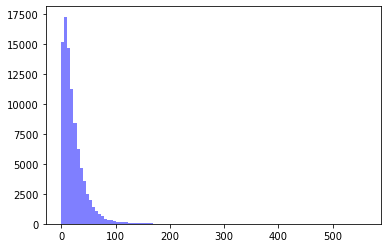

In [9]:
num_bins = 100
plt.hist(similarity_score.values(), num_bins, facecolor='blue', alpha=0.5)

In [10]:
key_list = list(similarity_score.keys())
val_list = list(similarity_score.values())

In [11]:
self_simi_score=dict()
for pheno in pheno_dict.columns:
    phenoset=pheno_dict[pheno][0].split(",")
    
    self_matchscore=p_hpo.compute_phenotype_match(phenoset, phenoset)
    self_simi_score[pheno]=self_matchscore

In [12]:
#scaled/normalized phrank score
scaled_simi_score=dict()
for key in similarity_score:
    key1=key.split('_')[0]
    key2=key.split('_')[1]
    denominator=max(self_simi_score[key1],self_simi_score[key2])
    scaled_simi_score[key]=similarity_score[key]/denominator

In [13]:
pd.Series(scaled_simi_score.values()).describe()

count    92235.000000
mean         0.085666
std          0.057112
min          0.000002
25%          0.043992
50%          0.076030
75%          0.116803
max          1.000000
dtype: float64

# Compute average phrank score of patients based on primary symptom category
## Still limit to patients with at least one (out of 657) significant gene

In [14]:
#average phrank score within group of patients with same primary symptoms
patients_primary_symp_category=pd.read_csv("patients_primary_symp_category.tsv",sep='\t')
patients_primary_symp_category.head()
patients_primary_symp_category['neurology_ids'][1]=0

/var/folders/5c/cfggjvm95676mlbgvhwsvcxw0000gn/T/ipykernel_50513/3628530429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_primary_symp_category['neurology_ids'][1]=0


In [15]:
average_phrank_scores=[]
empty_hpo_ids=["UDN258701","UDN760284","UDN102677","UDN770442"]
for category in patients_primary_symp_category.columns:
    if patients_primary_symp_category[category][0]!=patients_primary_symp_category[category][0]:
        average_phrank_scores.append(0)
        continue
    ids=patients_primary_symp_category[category][0].split(",")
    #print(ids)
    if len(ids)==1:
        average_phrank_scores.append(0)
        continue
    
    for empty_id in empty_hpo_ids:
        if empty_id in ids:
            ids.remove(empty_id)
            
    category_phrank_score=0
    for i,udn_id in enumerate(ids):
        j=i+1
        while j!=len(ids):
            if udn_id+"_"+ids[j] in scaled_simi_score.keys():
                category_phrank_score+=scaled_simi_score[udn_id+"_"+ids[j]]
            elif ids[j]+"_"+udn_id in scaled_simi_score.keys():
                category_phrank_score+=scaled_simi_score[ids[j]+"_"+udn_id]
            else:
                print(udn_id+"_"+ids[j])
            j+=1
    edge_num=len(ids)*(len(ids)-1)/2
    average_phrank_scores.append(category_phrank_score/edge_num)
                

In [16]:
average_phrank_scores

[0.09954947087680674,
 0.12440141399017728,
 0.0846073760504214,
 0.13349292558955952,
 0.13625477665429606,
 0,
 0.11476589596619051,
 0.10815957723231145,
 0.10878334807589846,
 0.12540691183958613,
 0.08149001107389732,
 0,
 0,
 0.3667709043141975,
 0,
 0.07791585647930202,
 0.08248033324930443,
 0]

In [18]:
print("Number of pairs with similarity score > 90: "+str(len([val for val in val_list if val>90])))
print("Number of pairs with scaled similarity score > 0.102319 (75%): "+str(len([scaled_val for scaled_val in scaled_val_list if scaled_val>0.102319])))

Number of pairs with similarity score > 90: 1557
Number of pairs with scaled similarity score > 0.102319 (75%): 29933


In [19]:
ordered_scaled_scores=scaled_val_list
ordered_scaled_scores.sort(reverse=True)
len(ordered_scaled_scores)
sorted_scaled_simi_score=dict(sorted(scaled_simi_score.items(), key=lambda item: item[1],reverse=True))
print("cutscore for the top 5% ",ordered_scaled_scores[int(len(ordered_scaled_scores) * .05)])

score for the top 5%  0.18991904634247728


In [20]:
scaled_similar_pair=[]
#ordered_scaled_scores=[scaled_val for scaled_val in scaled_val_list if scaled_val>0.1442532]
#ordered_scaled_scores.sort(reverse=True)
#top10_sorted_scaled_simi_score=[k for k, v in sorted_scaled_simi_score.items() if v > 0.1442531961606056]
top5_sorted_scaled_simi_score = {}
for k, v in sorted_scaled_simi_score.items():
    if v > 0.1899:
        top5_sorted_scaled_simi_score[k] = v

for i in top5_sorted_scaled_simi_score.keys():
    scaled_similar_set=set(i.split('_'))
    scaled_similar_pair.append(scaled_similar_set)
    
print("number of similar pairs with top5% scores: ",len(scaled_similar_pair))

number of similar pairs with top5% scores:  4613


In [31]:
pd.Series(top5_sorted_scaled_simi_score.values()).describe()

count    7052.000000
mean        0.214971
std         0.056168
min         0.171784
25%         0.184209
50%         0.201404
75%         0.229823
max         1.000000
dtype: float64

# Compute p-value for each of the scaled phrank score
## only significant p-values (<0.05)

In [21]:
#compute p_values for pairs whose p-values < 0.05
p_values=[]
list(sorted_scaled_simi_score.items())[0]
for index in range(len(sorted_scaled_simi_score)):
    score=list(sorted_scaled_simi_score.values())[index]
    if list(sorted_scaled_simi_score.values()).count(score)>1:
        if index==len(sorted_scaled_simi_score)-1:
            p_values.append(1)
            break
        dup_index=index+1
        dup_score=list(sorted_scaled_simi_score.values())[dup_index]
        while dup_score == score:
            if dup_index!=len(sorted_scaled_simi_score)-1:
                dup_index+=1
                dup_score=list(sorted_scaled_simi_score.values())[dup_index]
        p_value=dup_index/len(sorted_scaled_simi_score)
        if p_value>0.05:
            break
        p_values.append(p_value)
    else:
        p_value=index/len(sorted_scaled_simi_score)
        if p_value>0.05:
            break
        p_values.append(p_value)
        
 

In [22]:
print("The number of pairs with p-value <=0.05: ",len(p_values))

list(sorted_scaled_simi_score.keys())[4610],list(sorted_scaled_simi_score.values())[4610],p_values[4610]


The number of pairs with p-value <=0.05:  4611


('UDN789123_UDN764974', 0.18992276665315827, 0.04998102672521277)

In [23]:
#unique udn ids with significant p-values for phrank score
udn_id_sig_p_value=[]
for pair in list(sorted_scaled_simi_score.keys())[0:len(p_values)]:
    udn_pair=pair.split('_')
    for individual in udn_pair:
        if individual not in udn_id_sig_p_value:
            udn_id_sig_p_value.append(individual)
            


In [24]:
print("The number of patients with siginificant phrank score: ",len(udn_id_sig_p_value))

The number of patients with siginificant phrank score:  425


# Create similarity score matrix for clustering and visualization

In [25]:
similarity_matrix=pd.DataFrame(1, index=pheno_dict.columns, columns=pheno_dict.columns)

In [38]:
for key in scaled_simi_score.keys():
    key0=key.split("_")[0]
    key1=key.split("_")[1]
    similarity_matrix[key0][key1]=scaled_simi_score[key]
    similarity_matrix[key1][key0]=scaled_simi_score[key]
similarity_matrix      

/var/folders/5c/cfggjvm95676mlbgvhwsvcxw0000gn/T/ipykernel_22101/3542350231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarity_matrix[key1][key0]=scaled_simi_score[key]


,UDN480462,UDN018882,UDN229610,UDN765115,UDN499689,UDN970538,UDN786673,UDN560782,UDN765206,UDN849959,...,UDN278725,UDN343939,UDN033997,UDN795876,UDN010623,UDN490356,UDN117150,UDN452807,UDN658306,UDN699340
UDN480462,1.000000,0.046036,0.097613,0.141218,0.089587,0.084373,0.092255,0.110780,0.235128,0.077337,...,0.066051,0.060649,0.036653,0.029682,0.056106,0.071729,0.077699,0.103312,0.076608,0.114175
UDN018882,0.046036,1.000000,0.069322,0.040394,0.089122,0.070195,0.073763,0.060091,0.074952,0.172416,...,0.133882,0.113188,0.143262,0.053353,0.113320,0.032905,0.026972,0.049413,0.166502,0.032707
UDN229610,0.097613,0.069322,1.000000,0.097417,0.065316,0.116573,0.146381,0.123270,0.134887,0.187787,...,0.130106,0.113208,0.054991,0.066679,0.067708,0.152158,0.070443,0.089973,0.098335,0.243275
UDN765115,0.141218,0.040394,0.097417,1.000000,0.111252,0.070481,0.059172,0.114527,0.137035,0.058384,...,0.055542,0.076792,0.101046,0.042779,0.096580,0.140461,0.069042,0.063222,0.034724,0.206060
UDN499689,0.089587,0.089122,0.065316,0.111252,1.000000,0.095212,0.087113,0.188172,0.086715,0.168929,...,0.153996,0.173312,0.111638,0.163039,0.215532,0.124064,0.080723,0.212211,0.093512,0.051881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UDN490356,0.071729,0.032905,0.152158,0.140461,0.124064,0.091853,0.127217,0.126024,0.136127,0.085382,...,0.138422,0.136995,0.055715,0.195035,0.105101,1.000000,0.071543,0.131576,0.099678,0.086286
UDN117150,0.077699,0.026972,0.070443,0.069042,0.080723,0.100562,0.096933,0.093142,0.124384,0.066646,...,0.024468,0.044967,0.036893,0.162648,0.058346,0.071543,1.000000,0.063533,0.031249,0.061168
UDN452807,0.103312,0.049413,0.089973,0.063222,0.212211,0.118324,0.133620,0.160848,0.074323,0.075983,...,0.193336,0.245558,0.052516,0.113036,0.094876,0.131576,0.063533,1.000000,0.130552,0.064881
UDN658306,0.076608,0.166502,0.098335,0.034724,0.093512,0.101108,0.097833,0.101897,0.105783,0.133941,...,0.173178,0.318018,0.086482,0.091622,0.111180,0.099678,0.031249,0.130552,1.000000,0.041519


In [39]:
#similarity_matrix.to_csv("similarity_matrix.csv")

In [40]:
similarity_matrix_sig_p_value=pd.DataFrame(1, index=udn_id_sig_p_value, columns=udn_id_sig_p_value)

In [41]:
for key in sorted_scaled_simi_score.keys():
    #print(key)
    key0=key.split("_")[0]
    key1=key.split("_")[1]
    if key0 not in udn_id_sig_p_value or key1 not in udn_id_sig_p_value:
        continue
    similarity_matrix_sig_p_value[key0][key1]=sorted_scaled_simi_score[key]
    similarity_matrix_sig_p_value[key1][key0]=sorted_scaled_simi_score[key]
similarity_matrix_sig_p_value 

/var/folders/5c/cfggjvm95676mlbgvhwsvcxw0000gn/T/ipykernel_22101/2840444360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarity_matrix_sig_p_value[key1][key0]=sorted_scaled_simi_score[key]
/var/folders/5c/cfggjvm95676mlbgvhwsvcxw0000gn/T/ipykernel_22101/2840444360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarity_matrix_sig_p_value[key0][key1]=sorted_scaled_simi_score[key]


,UDN480462,UDN202218,UDN615361,UDN608261,UDN166867,UDN615127,UDN323373,UDN182483,UDN955918,UDN881997,...,UDN686410,UDN185245,UDN032050,UDN829699,UDN310485,UDN764074,UDN148702,UDN941156,UDN500889,UDN945671
UDN480462,1.000000,1.000000,0.100179,0.100179,0.000008,0.000008,0.194511,0.194511,0.024901,0.024901,...,0.101237,0.061569,0.012571,0.071926,0.017864,0.065166,0.048873,0.085870,0.075538,0.040109
UDN202218,1.000000,1.000000,0.100179,0.100179,0.000008,0.000008,0.194511,0.194511,0.024901,0.024901,...,0.101237,0.061569,0.012571,0.071926,0.017864,0.065166,0.048873,0.085870,0.075538,0.040109
UDN615361,0.100179,0.100179,1.000000,1.000000,0.007736,0.007736,0.138723,0.138723,0.066392,0.066392,...,0.085526,0.060241,0.025231,0.089641,0.000009,0.078235,0.072032,0.131543,0.075180,0.103842
UDN608261,0.100179,0.100179,1.000000,1.000000,0.007736,0.007736,0.138723,0.138723,0.066392,0.066392,...,0.085526,0.060241,0.025231,0.089641,0.000009,0.078235,0.072032,0.131543,0.075180,0.103842
UDN166867,0.000008,0.000008,0.007736,0.007736,1.000000,1.000000,0.000006,0.000006,0.072256,0.072256,...,0.025731,0.000008,0.000008,0.013518,0.000008,0.007736,0.000008,0.004916,0.000008,0.046191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UDN764074,0.065166,0.065166,0.078235,0.078235,0.007736,0.007736,0.032564,0.032564,0.058843,0.058843,...,0.006859,0.000013,0.000024,0.046753,0.000024,1.000000,0.055168,0.104663,0.000018,0.008734
UDN148702,0.048873,0.048873,0.072032,0.072032,0.000008,0.000008,0.055951,0.055951,0.019422,0.019422,...,0.090811,0.120575,0.037023,0.048572,0.011543,0.055168,1.000000,0.034065,0.123178,0.039679
UDN941156,0.085870,0.085870,0.131543,0.131543,0.004916,0.004916,0.039463,0.039463,0.045688,0.045688,...,0.020872,0.022754,0.000015,0.062758,0.000015,0.104663,0.034065,1.000000,0.026710,0.081862
UDN500889,0.075538,0.075538,0.075180,0.075180,0.000008,0.000008,0.117413,0.117413,0.000009,0.000009,...,0.043710,0.134067,0.052492,0.031670,0.000018,0.000018,0.123178,0.026710,1.000000,0.051884


In [42]:
#similarity_matrix_sig_p_value.to_csv("similarity_matrix_sig_p_value.csv")

In [43]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(similarity_matrix)
standard_embedding_sig = umap.UMAP(random_state=42).fit_transform(similarity_matrix_sig_p_value)

In [44]:
mapper=umap.UMAP(random_state=42).fit(similarity_matrix)
mapper_sig=umap.UMAP(random_state=42).fit(similarity_matrix_sig_p_value)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

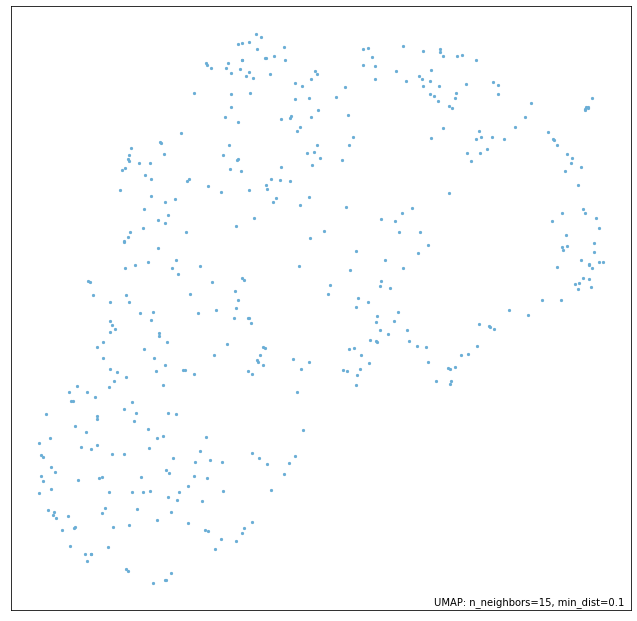

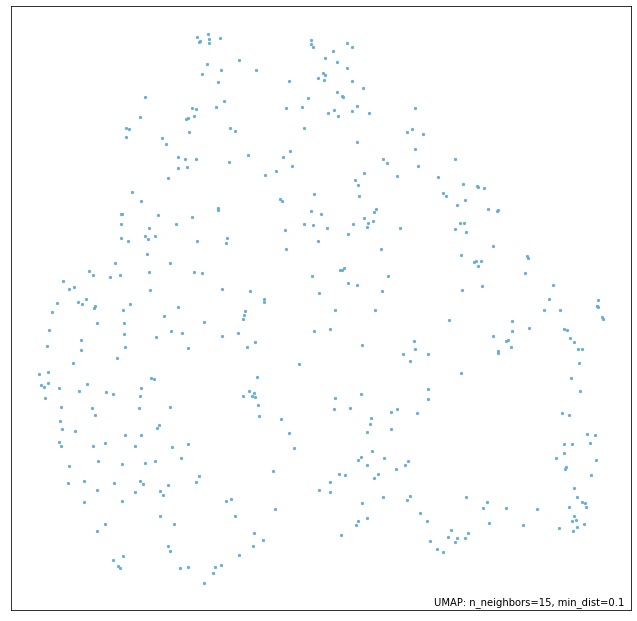

In [45]:
import umap.plot
umap.plot.points(mapper)
umap.plot.points(mapper_sig)

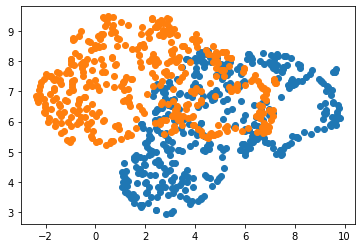

In [46]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1])
plt.scatter(standard_embedding_sig[:, 0], standard_embedding_sig[:, 1])

# Compute gene-patient phrank scores

In [26]:
annotated_file="Denovowest_result_annotated_restricted_udn_X_affected_657.tsv"
annotated_udn_X_denovo=pd.read_csv(annotated_file,sep='\t')

In [27]:
annotated_udn_X_denovo=annotated_udn_X_denovo.iloc[0:657,]

### Check how many significant genes can't be found in either gene-disease map or gene-pheno map

In [105]:
unique_ensembl_in_gene_pheno=[]
for gene in gene_pheno[1]:
    if gene not in unique_ensembl_in_gene_pheno:
        unique_ensembl_in_gene_pheno.append(gene)
        

In [122]:
unique_ensembl_in_gene_disease=[]
for gene in dis_gene[0]:
    if gene not in unique_ensembl_in_gene_disease:
        unique_ensembl_in_gene_disease.append(gene)

In [130]:
missing_gene_in_gene_pheno=[]
for gene in annotated_udn_X_denovo["ensembl_id"]:
    if (gene in unique_ensembl_in_gene_pheno or gene in unique_ensembl_in_gene_disease)==False:
        missing_gene_in_gene_pheno.append(gene)

print(len(missing_gene_in_gene_pheno),"genes can't be found in either map")

437 genes can't be found in either map


In [28]:
gene_patient_dict={}
for i in range(len(annotated_udn_X_denovo)):
    gene_patient_dict[annotated_udn_X_denovo["ensembl_id"][i]]=annotated_udn_X_denovo["udn_id"][i].split("|")

In [30]:
#Compute gene_patient phrank score
empty_hpo_ids=["UDN258701","UDN760284","UDN102677","UDN770442"]
phrank_score_gene_patient={}
for gene, patients in gene_patient_dict.items():
    phrank_score_gene_patient[gene]=[]
    patient_genes = set([gene])
    #print("Gene: "+str(gene))
    for patient in patients:
        if patient in empty_hpo_ids:
            continue
        #print("Patient: "+patient)
        patient_phenotypes = pheno_dict[patient][0].split(',')

        # sorting the disease by best match
        disease_ranking = p_hpo.rank_diseases(patient_genes, patient_phenotypes)
        #print ("Disease ranking")
        #for disease_info in disease_ranking:
            #print ("disease id: %s\tsimilarity score: %.2f"%(disease_info[1],disease_info[0]))

        # sorting the genes by best match
        gene_ranking = p_hpo.rank_genes(patient_genes, patient_phenotypes,normalized=True)
        #print ("Gene ranking")
        for gene_info in gene_ranking:
            #print ("ensembl gene id: %s\tsimilarity score: %.2f"%(gene_info[1],gene_info[0]))
            phrank_score_gene_patient[gene].append([patient,gene_info[0]])
        #print('\n')
        

In [31]:
list(phrank_score_gene_patient.items())[0:5]

[('ENSG00000255823', []),
 ('ENSG00000272333',
  [['UDN187074', 0.0704186827310182],
   ['UDN306319', 0.0704186827310182],
   ['UDN067966', 0.32602262572271745],
   ['UDN021466', 0.2961372406948136]]),
 ('ENSG00000141837',
  [['UDN101955', 0.5958376673770781],
   ['UDN480462', 0.25258967113258657],
   ['UDN893258', 0.3757175745310793]]),
 ('ENSG00000115216', []),
 ('ENSG00000145348',
  [['UDN177234', 0.1565576523978795], ['UDN287604', 0.3215755508337502]])]

In [140]:
count=0
for key in phrank_score_gene_patient.keys():
    if phrank_score_gene_patient[key]==[]:
        count+=1
        
print(count,"significant genes don't have gene-patient phrank score.")

451 significant genes don't have gene-patient phrank score.


## Plot correlation between gene-patient phrank score and p-value generated by DeNovoWEST for each gene

In [68]:
from itertools import repeat
x_gene_patient_phrank_score=[]
y_gene_p_value=[]
for index, gene in enumerate(phrank_score_gene_patient.keys()):
    if phrank_score_gene_patient[gene] != []:
        for pat in phrank_score_gene_patient[gene]:
            x_gene_patient_phrank_score.append(pat[1])
        p_value=annotated_udn_X_denovo['p-value'][index]
        y_gene_p_value.extend(repeat(p_value,len(phrank_score_gene_patient[gene])))

In [143]:
pd.Series(x_gene_patient_phrank_score).describe()

count    246.000000
mean       0.179965
std        0.147762
min        0.000016
25%        0.070779
50%        0.148166
75%        0.252283
max        0.752210
dtype: float64

slope:  5.00421468880469


Text(0, 0.5, 'P-value of significant gene')

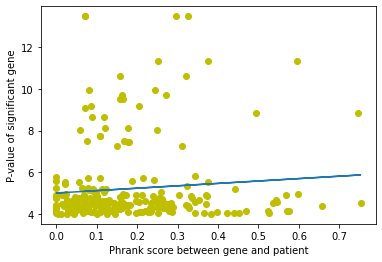

In [96]:
import math
#y_gene_p_value=[]
coef = np.polyfit(x_gene_patient_phrank_score,[-1*math.log10(a) for a in y_gene_p_value],1)
print("slope: ",coef[1])
poly1d_fn = np.poly1d(coef) 
plt.plot(x_gene_patient_phrank_score,[-1*math.log10(a) for a in y_gene_p_value],'yo', x_gene_patient_phrank_score,poly1d_fn(x_gene_patient_phrank_score))
plt.xlabel("Phrank score between gene and patient")
plt.ylabel("P-value of significant gene")


# Self-invented algorithm to group patients based on phrank score

In [96]:
#group patients
#no threshold

def generate_similar_groups_no_threshold(similar_groups, ave_score_edge_num, similar_pair, key_list, val_list, percent, cut_off_list,sd):
    for num, pair in enumerate(similar_pair):
        group_id=0
        print("pair "+str(pair))
        ave_score_decrement=[]
        while group_id < len(similar_groups):
            group=similar_groups[group_id]
            patient0=list(pair)[0]
            patient1=list(pair)[1]
            if patient0+'_'+patient1 in key_list:
                key=patient0+'_'+patient1
            else:
                key=patient1+'_'+patient0
                
            if patient0 in group and patient1 in group:#both patients are in the existing group
                break#proceed to next pair
            
            elif patient0 not in group and patient1 not in group:#both patients are not in the existing group
                ave_score_decrement.append(100)#assign a large number as the ave_score_decrement
                    
                if group_id == len(similar_groups)-1:#if reach the last group (have looped through all groups)
                    if min(ave_score_decrement)==100:
                        similar_groups.append(pair)
                        ave_score_edge_num.append([val_list[key_list.index(key)],1])
                        cut_off_list.append(val_list[key_list.index(key)]-3*sd)
                    else:
                        group_index=ave_score_decrement.index(min(ave_score_decrement))
                        similar_groups[group_index] = similar_groups[group_index].union(pair)
                        ave_score_edge_num[group_index][0]-=ave_score_decrement[group_index]
                        ave_score_edge_num[group_index][1]=len(similar_groups[group_index])*(len(similar_groups[group_index])-1)/2
                    break
                else:
                    group_id+=1
                    continue
                    
            elif patient0 in group and patient1 not in group:#one of the patients in the existing group
                alt_patient=patient1
            else:
                alt_patient=patient0
                
            scores_to_add=0
            for exist_patient in list(group):
                query_pair1=alt_patient+'_'+exist_patient
                query_pair2=exist_patient+'_'+alt_patient
                if query_pair1 in key_list:
                    position=key_list.index(query_pair1)
                    scores_to_add+=val_list[position]
                elif query_pair2 in key_list:
                    position=key_list.index(query_pair2)
                    scores_to_add+=val_list[position]
            new_ave_score=(ave_score_edge_num[group_id][0]*ave_score_edge_num[group_id][1]+scores_to_add)/(ave_score_edge_num[group_id][1]+len(group))
            #if the new average score after adding the new patient will not decrease the initial average score by 
            #more than usered-specific ## percent and the new average score will not drop below the user-specific cutoff
            if new_ave_score>percent*ave_score_edge_num[group_id][0] and new_ave_score>cut_off_list[group_id]:
                ave_score_decrement.append(ave_score_edge_num[group_id][0]-new_ave_score)
            else:
                ave_score_decrement.append(100)
                
            if group_id == len(similar_groups)-1:
                if min(ave_score_decrement)==100:
                    similar_groups.append(pair)
                    ave_score_edge_num.append([val_list[key_list.index(key)],1])
                    cut_off_list.append(val_list[key_list.index(key)]-3*sd)
                else:
                    group_index=ave_score_decrement.index(min(ave_score_decrement))
                    similar_groups[group_index] = similar_groups[group_index].union(pair)
                    ave_score_edge_num[group_index][0]-=ave_score_decrement[group_index]
                    ave_score_edge_num[group_index][1]=len(similar_groups[group_index])*(len(similar_groups[group_index])-1)/2
                break
            else:
                group_id+=1
            
    return similar_groups, ave_score_edge_num


In [53]:
scaled_similar_groups=[scaled_similar_pair[0]]
print(scaled_similar_groups)
p0=list(scaled_similar_pair[0])[1]
p1=list(scaled_similar_pair[0])[0]
sd=0.0556
scaled_ave_score_edge_num=[[top5_sorted_scaled_simi_score[p0+"_"+p1],1]]
cut_off_list=[scaled_ave_score_edge_num[0][0]-3*sd]
percent=0.8

scaled_similar_groups,scaled_ave_score_edge_num=generate_similar_groups_no_threshold(scaled_similar_groups, scaled_ave_score_edge_num, scaled_similar_pair, list(top5_sorted_scaled_simi_score.keys()), list(top5_sorted_scaled_simi_score.values()), percent,cut_off_list,sd)
#print('\n')
#print("scaled similar_groups: "+str(scaled_similar_groups))
#print("scaled ave_score_edge_num: "+str(scaled_ave_score_edge_num))


In [51]:
#A&B>90 AND B&C>90 AND A&C>90--> {A,B,C}

def union_similar_patients(pair,in_group_index,group,similar_groups,group_id,key_list,val_list,threshold):
    indicator=0
    if in_group_index ==0:
        alt_patient=list(pair)[1]
    else:
        alt_patient=list(pair)[0]
    for exist_patient in list(group):
        query_pair1=alt_patient+'_'+exist_patient
        query_pair2=exist_patient+'_'+alt_patient
        if query_pair1 in key_list:
            position=key_list.index(query_pair1)
        elif query_pair2 in key_list:
            position=key_list.index(query_pair2)

        if val_list[position]<threshold:
            break
        if exist_patient==list(group)[len(group)-1]:#all pair-wise simi score >90
                similar_groups[group_id] = group.union(pair)
                indicator=1
    return similar_groups,indicator
        
def generate_similar_groups_plus_threshold(similar_groups, similar_pair,key_list,val_list,threshold):
    for pair in similar_pair:
        group_id=0
        while group_id < len(similar_groups):
            group=similar_groups[group_id]
            patient0=list(pair)[0]
            patient1=list(pair)[1]
            if patient0 in group and patient1 not in group:
                similar_groups,indicator=union_similar_patients(pair,0,group,similar_groups,group_id,key_list,val_list,threshold)
                if indicator ==1:
                    break
                else:
                    if group_id == len(similar_groups)-1:
                        similar_groups.append(pair)
                        break
                    else:
                        group_id+=1
                
            elif patient1 in group and patient0 not in group:
                similar_groups,indicator=union_similar_patients(pair,1,group,similar_groups,group_id,key_list,val_list,threshold)
                if indicator ==1:
                    break
                else:
                    if group_id == len(similar_groups)-1:
                        similar_groups.append(pair)
                        break
                    else:
                        group_id+=1
                
            elif patient0 in group and patient1 in group:
                break
            else:
                #print("two patients not in group")
                similar_groups,indicator1=union_similar_patients(pair,0,group,similar_groups,group_id,key_list,val_list,threshold)
                similar_groups,indicator2=union_similar_patients(pair,1,group,similar_groups,group_id,key_list,val_list,threshold)
                if indicator1==1 & indicator2==1:
                    break
                if group_id == len(similar_groups)-1:
                    similar_groups.append(pair)
                    break
                else:
                    group_id+=1
    return similar_groups

similar_groups=[similar_pair[0]]
similar_groups=generate_similar_groups_plus_threshold(similar_groups,similar_pair,key_list,val_list,45)
print('\n')
print("similar_groups: "+str(similar_groups))  

In [52]:
scaled_similar_groups=[scaled_similar_pair[0]]
scaled_similar_groups=generate_similar_groups_plus_threshold(scaled_similar_groups,scaled_similar_pair,scaled_key_list,scaled_val_list,0.3)
print('\n')
print("scaled similar_groups: "+str(scaled_similar_groups))  

In [48]:
#A&B>90 AND B&C>90 --> {A,B,C}

def generate_similar_groups(similar_groups,similar_pair,merge=True):
    for pair in similar_pair:
        group_id=0
        while group_id < len(similar_groups):
            group=similar_groups[group_id]
            if any(patient in group for patient in pair):
                similar_groups[group_id] = group.union(pair)
                indicator=1
                break
            
            if group_id == len(similar_groups)-1:
                similar_groups.append(pair)
                #print(similar_groups)
                break
            group_id+=1
        
    #print("similar_groups before merge: "+str(similar_groups))
    
    #merge groups
    if merge ==True:
        group_id=0
        while group_id < len(similar_groups)-1:
            indicator=0
            cur_group=similar_groups[group_id]
    
            for following_id in range(group_id+1, len(similar_groups)):
                
                following_group=similar_groups[following_id]
                
                if any(ele in cur_group for ele in following_group):
                    similar_groups[group_id]=cur_group.union(following_group)
                    similar_groups.remove(following_group)
                    group_id=0
                    indicator=1
                    break
            if indicator==0:
                group_id+=1
    
    #print("similar_groups after merge: "+str(similar_groups)) 
    return similar_groups

similar_groups=[similar_pair[0]]
similar_groups_nomerge=generate_similar_groups(similar_groups,similar_pair,merge=False)
similar_groups=[similar_pair[0]]
similar_groups_merge=generate_similar_groups(similar_groups,similar_pair,merge=True)
#print('\n')
print("similar_groups before merge: "+str(similar_groups_nomerge))
print("similar_groups after merge: "+str(similar_groups_merge))

similar_groups before merge: [{'UDN679700', 'UDN731209', 'UDN908105', 'UDN264668', 'UDN207423', 'UDN055658', 'UDN806854', 'UDN350613', 'UDN483030', 'UDN565695', 'UDN849344', 'UDN101955', 'UDN049434', 'UDN809795', 'UDN021466', 'UDN388987', 'UDN817437', 'UDN879158', 'UDN226420', 'UDN604960', 'UDN574234', 'UDN789579', 'UDN429873', 'UDN348954', 'UDN929405', 'UDN140915', 'UDN658306', 'UDN338723', 'UDN426473', 'UDN787413', 'UDN293334'}, {'UDN929405', 'UDN565695', 'UDN140915', 'UDN101955', 'UDN021466'}, {'UDN849344', 'UDN348954', 'UDN817437'}]
similar_groups after merge: [{'UDN679700', 'UDN731209', 'UDN908105', 'UDN264668', 'UDN207423', 'UDN055658', 'UDN806854', 'UDN350613', 'UDN483030', 'UDN565695', 'UDN849344', 'UDN101955', 'UDN049434', 'UDN809795', 'UDN021466', 'UDN388987', 'UDN817437', 'UDN879158', 'UDN226420', 'UDN604960', 'UDN574234', 'UDN789579', 'UDN429873', 'UDN348954', 'UDN929405', 'UDN140915', 'UDN658306', 'UDN338723', 'UDN426473', 'UDN787413', 'UDN293334'}]


In [125]:
scaled_similar_groups=[scaled_similar_pair[0]]
scaled_similar_groups_nomerge=generate_similar_groups(scaled_similar_groups,scaled_similar_pair,merge=False)
scaled_similar_groups=[scaled_similar_pair[0]]
scaled_similar_groups_merge=generate_similar_groups(scaled_similar_groups,scaled_similar_pair,merge=True)
#print('\n')
print("scaled similar_groups before merge: "+str(scaled_similar_groups_nomerge))
print("scaled similar_groups after merge: "+str(scaled_similar_groups_merge))

scaled similar_groups before merge: [{'UDN731209', 'UDN226420', 'UDN338723', 'UDN429873'}, {'UDN426473', 'UDN264668', 'UDN207423', 'UDN177234', 'UDN789579', 'UDN775476', 'UDN021466', 'UDN849344', 'UDN565695', 'UDN140915', 'UDN101955', 'UDN550179', 'UDN335659', 'UDN338797', 'UDN817437', 'UDN291411'}, {'UDN207423', 'UDN348954', 'UDN021466', 'UDN849344', 'UDN140915', 'UDN335659', 'UDN426473', 'UDN817437'}, {'UDN789123', 'UDN929405', 'UDN565695', 'UDN140915', 'UDN101955', 'UDN021466', 'UDN879158'}, {'UDN081722', 'UDN345959'}, {'UDN500889', 'UDN154050'}, {'UDN984078', 'UDN221071', 'UDN265815', 'UDN010623', 'UDN737629', 'UDN151434', 'UDN378975', 'UDN823739'}, {'UDN426473', 'UDN264668'}, {'UDN406184', 'UDN418056'}, {'UDN008634', 'UDN287604'}, {'UDN184552', 'UDN122793'}, {'UDN191879', 'UDN454712'}, {'UDN457425', 'UDN431179'}, {'UDN523060', 'UDN970538'}]
scaled similar_groups after merge: [{'UDN731209', 'UDN226420', 'UDN338723', 'UDN429873'}, {'UDN338797', 'UDN264668', 'UDN207423', 'UDN775476',